In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
columns = ['id','entity','sentiment','content']
df = pd.read_csv('twitter_training.csv',names=columns)
test = pd.read_csv('twitter_validation.csv',names=columns)

In [3]:
df.head()

,id,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74682 non-null  int64 
 1   entity     74682 non-null  object
 2   sentiment  74682 non-null  object
 3   content    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [5]:
df['sentiment'].value_counts()

sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

In [6]:
df.drop(columns=['id','entity'],inplace=True,axis=1)
test.drop(columns=['id','entity'],inplace=True,axis=1)


In [7]:
df.head()

,sentiment,content
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


C:\Users\Dell\AppData\Local\Temp\ipykernel_23340\1797644557.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', order=df['sentiment'].value_counts().index, palette='Set2')


Text(0, 0.5, 'Count')

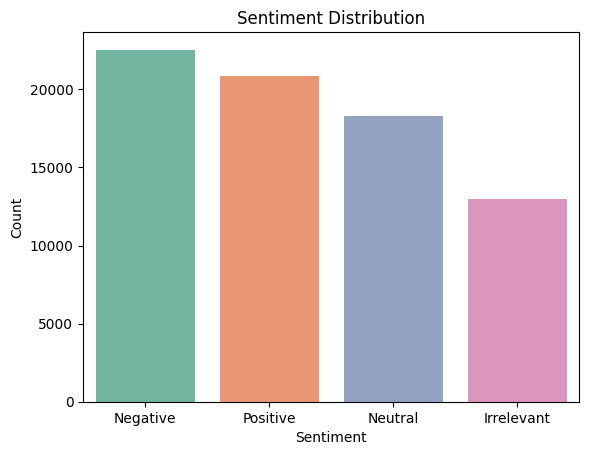

In [8]:
sns.countplot(data=df, x='sentiment', order=df['sentiment'].value_counts().index, palette='Set2')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

In [9]:
df['content'][0]

'im getting on borderlands and i will murder you all ,'

In [10]:
df.isna().sum()

sentiment      0
content      686
dtype: int64

In [11]:
df.dropna(inplace=True)

In [12]:
df.isna().sum()

sentiment    0
content      0
dtype: int64

In [13]:
df.shape

(73996, 2)

In [14]:
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

In [15]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+|#', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)  

In [17]:
df['content'] = df['content'].apply(clean_text)
test['content'] = test['content'].apply(clean_text)

In [18]:
df['content'][0]

'im getting borderland murder'

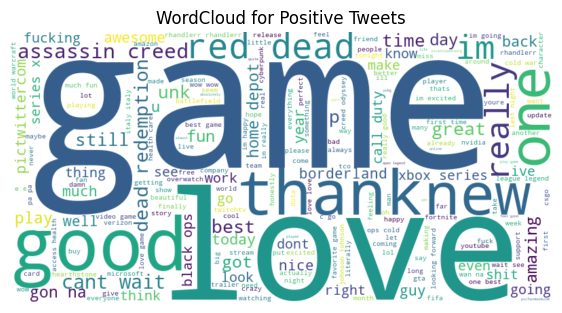

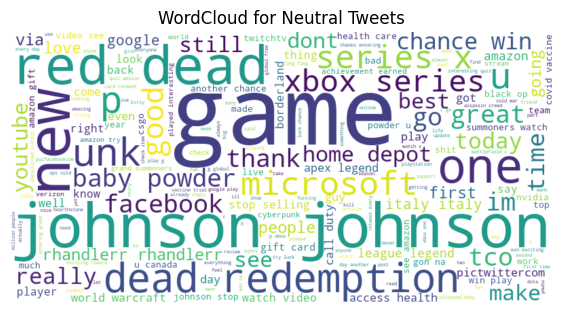

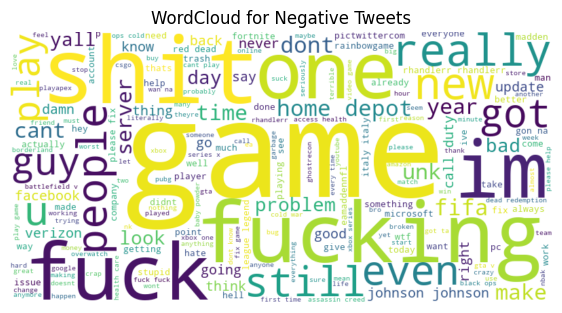

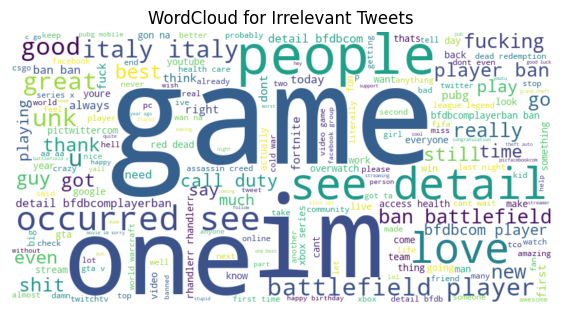

In [19]:
from wordcloud import WordCloud

sentiments = df['sentiment'].unique()

for sentiment in sentiments:
    text = ' '.join(df[df['sentiment'] == sentiment]['content'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(7, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {sentiment} Tweets')
    plt.show()

In [20]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
df['label'] = label.fit_transform(df['sentiment'])

In [21]:
test['label'] = label.transform(test['sentiment'])

In [22]:
df.head()

,sentiment,content,label
0,Positive,im getting borderland murder,3
1,Positive,coming border kill,3
2,Positive,im getting borderland kill,3
3,Positive,im coming borderland murder,3
4,Positive,im getting borderland murder,3


In [23]:
y=df['label']

In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [28]:
MAX_WORDS = 5000
MAX_LEN = 100
EMBEDDING_DIM = 100

In [29]:
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df['content'])

In [30]:
X_train = tokenizer.texts_to_sequences(df['content'])
X_val = tokenizer.texts_to_sequences(test['content'])

In [31]:
X_train = pad_sequences(X_train, maxlen=MAX_LEN)
X_val = pad_sequences(X_val, maxlen=MAX_LEN)

In [32]:
y_train = tf.keras.utils.to_categorical(df['label'])
y_val = tf.keras.utils.to_categorical(test['label'])

In [61]:
y_train[0]

array([0., 0., 0., 1.])

In [34]:
model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))  
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

d:\Data Science\Twitter Sentimental Analysis\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [35]:
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/5
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 181s 153ms/step - accuracy: 0.4800 - loss: 1.1555 - val_accuracy: 0.7860 - val_loss: 0.6191
Epoch 2/5
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 176s 153ms/step - accuracy: 0.7284 - loss: 0.7151 - val_accuracy: 0.8450 - val_loss: 0.4440
Epoch 3/5
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 177s 153ms/step - accuracy: 0.7915 - loss: 0.5560 - val_accuracy: 0.8850 - val_loss: 0.3646
Epoch 4/5
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 175s 151ms/step - accuracy: 0.8250 - loss: 0.4609 - val_accuracy: 0.8960 - val_loss: 0.3393
Epoch 5/5
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 188s 162ms/step - accuracy: 0.8530 - loss: 0.3931 - val_accuracy: 0.9120 - val_loss: 0.3012


In [36]:
model.save('model.h5')

In [47]:
text = "2010 So I spent a few hours making something for fun. . . If you don't know I am a HUGE RhandlerR fan and Maya is one of my favorite characters. So I decided to make myself a wallpaper for my PC. . Here is the original image versus the creation I made :) Enjoy! pic.twitter.com/mLsI5wf9Jg"
text = clean_text(text)


In [48]:
seq = tokenizer.texts_to_sequences([clean_text(text)])

In [51]:
seq

[[711,
  151,
  207,
  134,
  57,
  18,
  42,
  323,
  36,
  210,
  3070,
  5,
  204,
  234,
  622,
  26,
  167,
  587,
  1134,
  4308,
  117,
  295]]

In [49]:
padded = pad_sequences(seq, maxlen=MAX_LEN)

In [50]:
padded

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  711,  151,  207,  134,   57,   18,   42,  323,   36,  210,
        3070,    5,  204,  234,  622,   26,  167,  587, 1134, 4308,  117,
         295]], dtype=int32)

In [53]:
probs = model.predict(padded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


In [55]:
pred_label_idx = np.argmax(probs)

In [56]:
pred_label = label.inverse_transform([pred_label_idx])[0]

In [57]:
pred_label

'Positive'

In [62]:
import pickle
with open('encoder.pkl','wb') as file:
    pickle.dump(label,file)

In [63]:
with open('tokenizer.pkl','wb') as file:
    pickle.dump(tokenizer,file)